# Summarizing Text with Amazon Reviews

In [0]:
import json
import io
import re
import os
import time
import random
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import unicodedata
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

## 1）Read Data

In [5]:
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

reviews = pd.read_csv("drive/My Drive/Colab Notebooks/data/Reviews.csv")

In [16]:
reviews[reviews.index == 835]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
835,836,B001ELL9X6,A38OVPNVBVUO9Y,"T. Burton ""Hakalau Tom""",0,0,5,1349222400,great organic tea at a great price,"<a href=""http://www.amazon.com/gp/product/B001..."


In [0]:
reviews = reviews.head(5000)

In [0]:
# Remove null values and unneeded features
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
                        'Score','Time'], 1)
reviews = reviews.reset_index(drop=True)

In [19]:
reviews.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [20]:
reviews.columns

Index(['Summary', 'Text'], dtype='object')

In [21]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #",i+1)
    print(reviews.Summary[i])
    print(reviews.Text[i])
    print()

Review # 1
Good Quality Dog Food
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Review # 2
Not as Advertised
Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Review # 3
"Delight" says it all
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces 

## 2) Text Preprocessing

#### 1) Text Cleaning

In [0]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"}

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# # Load Conceptnet Numberbatch's (CN) embeddings, similar to GloVe, but probably better 
# # (https://github.com/commonsense/conceptnet-numberbatch)
# embeddings_index = {}
# with open('./data/numberbatch-en.txt', encoding='utf-8') as f:
#     for line in f:
#         values = line.split(' ')
#         word = values[0]
#         embedding = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = embedding

# print('Word embeddings:', len(embeddings_index))

In [0]:
max_length = 150

In [0]:
def preprocess_sentence(sentence,remove_stopwords):
    
    sentence = " ".join([contractions[word] if word in contractions else word for word in sentence.lower().split(' ') ])
    
    sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'\<a href', ' ', sentence)
    sentence = re.sub(r'&amp;', '', sentence) 
    sentence = re.sub(r'[_"~\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', sentence)
    sentence = re.sub(r'<br />', ' ', sentence)
    sentence = re.sub(r'<br>', ' ', sentence)
    sentence = re.sub(r'>', ' ', sentence)
    sentence = re.sub(r'<', ' ', sentence)
    sentence = re.sub(r'\'', ' ', sentence)
    
    # Optionally, remove stop words
    if remove_stopwords:
        sentence = sentence.split()
        stops = set(stopwords.words("english"))
        sentence = [w for w in sentence if not w in stops]
        sentence = " ".join(sentence)
        
    sentence = " ".join(sentence.split()[:max_length])
    
#     sentence += ' .'
    
#     sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [0]:
sentence = "If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal."

In [28]:
preprocess_sentence(sentence,True)

'looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal'

In [0]:
reviews['Text'] = reviews.apply(lambda row: preprocess_sentence(row['Text'],True),axis = 1)

In [30]:
reviews.head()

,Summary,Text
0,Good Quality Dog Food,bought several vitality canned dog food produc...
1,Not as Advertised,product arrived labeled jumbo salted peanuts p...
2,"""Delight"" says it all",confection around centuries light pillowy citr...
3,Cough Medicine,looking secret ingredient robitussin believe f...
4,Great taffy,great taffy great price wide assortment yummy ...


In [0]:
reviews['Summary'] = reviews.apply(lambda row: preprocess_sentence(row['Summary'],False),axis = 1)

In [32]:
reviews.head()

,Summary,Text
0,good quality dog food,bought several vitality canned dog food produc...
1,not as advertised,product arrived labeled jumbo salted peanuts p...
2,delight says it all,confection around centuries light pillowy citr...
3,cough medicine,looking secret ingredient robitussin believe f...
4,great taffy,great taffy great price wide assortment yummy ...


In [0]:
reviews['text_length'] = [len(text.split()) for text in reviews['Text']]

In [34]:
reviews.sort_values(by='text_length')

,Summary,Text,text_length
4466,woderful wild rasberry french twists,,0
713,these chips are addictive,,0
1345,wish bone fat free ranch dressing,,0
2032,family breakfast grand kids kids 20 of us,,0
2304,great low calorie treat for overweight dogs or...,,0
...,...,...,...
2943,kitty junk food,five cats one elderly cat 15 years four 9 11 y...,150
2946,kitty junk food,five cats one elderly cat 15 years four 9 11 y...,150
73,warning warning alcohol sugars,buyer beware please sweetener everybody maltit...,150
4552,one of the best decaffeninated coffees i have ...,coffee fan drinks coffee black nothing added a...,150


In [0]:
def add_token(sentence):
    sentence += ' .'
    
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [0]:
reviews['Summary'] = reviews.apply(lambda row: add_token(row['Summary']),axis = 1)

In [0]:
reviews['Text'] = reviews.apply(lambda row: add_token(row['Text']),axis = 1)

In [0]:
reviews.index = range(len(reviews))

In [39]:
# Inspecting some of the reviews
for i in range(5):
    print("Review #",i+1)
    print(reviews.Summary[i])
    print(reviews.Text[i])
    print()

Review # 1
<start> good quality dog food . <end>
<start> bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better . <end>

Review # 2
<start> not as advertised . <end>
<start> product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo . <end>

Review # 3
<start> delight says it all . <end>
<start> confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch . <end>

Review # 4
<start> cough medicine . <end>
<start> looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal . <end>

Review # 5
<start> great taffy . <en

#### 1) Text Cleaning

In [0]:
def get_max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    
    return tensor, lang_tokenizer

In [0]:
def load_dataset():

    targ_lang, inp_lang = reviews['Summary'].values,reviews['Text'].values
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
input_tensor, output_tensor, input_tokenizer, output_tokenizer = load_dataset()

max_length_targ, max_length_inp = get_max_length(output_tensor), get_max_length(input_tensor)

In [43]:
max_length_targ, max_length_inp

(33, 153)

In [44]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, output_tensor_train, output_tensor_val = train_test_split(input_tensor, output_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(output_tensor_train), len(input_tensor_val), len(output_tensor_val))

4000 4000 1000 1000


In [0]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [46]:
input_tokenizer.index_word[4]

'br'

In [47]:
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor_train[30])
print ()
print ("Target Language; index to word mapping")
convert(output_tokenizer, output_tensor_train[30])

Input Language; index to word mapping
1 ----> <start>
5335 ----> koeze
11386 ----> colossal
2470 ----> cashews
60 ----> delicious
2470 ----> cashews
86 ----> ever
166 ----> tasted
655 ----> huge
4 ----> br
2195 ----> kidding
896 ----> call
4417 ----> jumbo
421 ----> flavorful
4 ----> br
58 ----> order
256 ----> disappointed
4 ----> br
577 ----> expect
276 ----> wish
94 ----> ordered
443 ----> larger
127 ----> size
2 ----> .
3 ----> <end>

Target Language; index to word mapping
1 ----> <start>
9 ----> best
2775 ----> cashews
2 ----> .
3 ----> <end>


#### 3) DataSet Creating

In [48]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, output_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 153]), TensorShape([64, 33]))

In [49]:
example_input_batch

<tf.Tensor: shape=(64, 153), dtype=int32, numpy=
array([[   1,   10,  275, ...,    0,    0,    0],
       [   1,  131,   49, ...,    0,    0,    0],
       [   1,    7,   10, ...,    0,    0,    0],
       ...,
       [   1,  150, 7610, ...,    0,    0,    0],
       [   1,   24, 1131, ...,    0,    0,    0],
       [   1,  315,   39, ...,    0,    0,    0]], dtype=int32)>

## 3) Transformer

##### (1 )Positional encoding

In [0]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### (2) Mask

In [0]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [0]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#### (3) Multi-head Attention


In [0]:
def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。

    参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。

    返回值:
    输出，注意力权重
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

#### (4) Point wise feed forward network

In [0]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

#### (5) Encoder Layer and Decoder Layers

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [0]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

#### (5) Transfomer

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [62]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

#### (5) hyperparameters

In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(input_tokenizer.word_index)+2
target_vocab_size = len(output_tokenizer.word_index) + 2
dropout_rate = 0.1

### (4) Optimizer

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

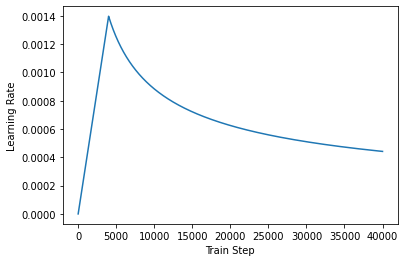

In [66]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### (5) Loss and metrics

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### (6) Transformer Model

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

### (7) Train Function

In [0]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)

    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [0]:
EPOCHS = 100

In [0]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

### (8) Training

In [77]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.5309 Accuracy 0.0908
Epoch 1 Batch 50 Loss 0.5577 Accuracy 0.0931
Epoch 1 Loss 0.5625 Accuracy 0.0932
Time taken for 1 epoch: 14.660086154937744 secs

Epoch 2 Batch 0 Loss 0.5468 Accuracy 0.0913
Epoch 2 Batch 50 Loss 0.5294 Accuracy 0.0964
Epoch 2 Loss 0.5350 Accuracy 0.0963
Time taken for 1 epoch: 14.5689377784729 secs

Epoch 3 Batch 0 Loss 0.4077 Accuracy 0.0962
Epoch 3 Batch 50 Loss 0.5072 Accuracy 0.0999
Epoch 3 Loss 0.5085 Accuracy 0.0996
Time taken for 1 epoch: 14.533266544342041 secs

Epoch 4 Batch 0 Loss 0.5029 Accuracy 0.0991
Epoch 4 Batch 50 Loss 0.4805 Accuracy 0.1018
Epoch 4 Loss 0.4822 Accuracy 0.1023
Time taken for 1 epoch: 14.669723510742188 secs

Epoch 5 Batch 0 Loss 0.4372 Accuracy 0.1035
Epoch 5 Batch 50 Loss 0.4543 Accuracy 0.1060
Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-5
Epoch 5 Loss 0.4557 Accuracy 0.1061
Time taken for 1 epoch: 15.021337985992432 secs

Epoch 6 Batch 0 Loss 0.4215 Accuracy 0.1069
Epoch 6 Batch 50 Loss 0.4306

In [0]:
def evaluate(inp_sentence):
    start_token = [len(input_tokenizer.word_index)]
    end_token = [len(input_tokenizer.word_index) + 1]

    inp_sentence = [input_tokenizer.word_index[word] for word in add_token(preprocess_sentence(sentence,remove_stopwords=True)).split()]
    
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 因为目标是英语，输入 transformer 的第一个词应该是
    # 英语的开始标记。
    decoder_input = [len(output_tokenizer.word_index)]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # 从 seq_len 维度选择最后一个词
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # 如果 predicted_id 等于结束标记，就返回结果
    if predicted_id == output_tokenizer.word_index['<end>']:
        return tf.squeeze(output, axis=0), attention_weights
    
    # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
    output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

In [0]:
def summary(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = " ".join([output_tokenizer.index_word[id] for id in result.numpy()])

    print('Input: {}'.format(sentence))
    print('Predicted summary: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [0]:
reviews = pd.read_csv("drive/My Drive/Colab Notebooks/data/Reviews.csv")

In [114]:
# Inspecting some of the reviews
i = 100
print("Review #",i+1)
print(reviews.Summary[i])
print(reviews.Text[i])

Review # 101
Taste wise it is a 6 star item
The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


In [0]:
sentence = reviews.Text[i]

In [116]:
summary(sentence)

Input: The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.
Predicted summary: rainforest tea
